# 1. Import Packages

In [1]:
import numpy as np 
import pandas as pd 
import nltk
import matplotlib.pyplot as plt
import random
import re
import string
import pickle
from nltk.corpus import stopwords # module for stop words
from nltk.stem import PorterStemmer # module for stemming
from nltk.tokenize import TweetTokenizer # module for tokenizing strings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# download the stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Data Cleaning

## 2.1. Explore the dataset
Look at the number of training dataset that is with label 1 (related to disaster) versus lable 0 (not related to disaster)

In [3]:
# import train dataset
raw_df = pd.read_csv("/kaggle/input/nlpgettingstarted/train.csv")
test_df = pd.read_csv("/kaggle/input/nlpgettingstarted/test.csv")
# check the number of dataset with label 1 and 0 
print("number of disaster sample:", len(raw_df[raw_df["target"] == 1]))
print("number of not disaster sample:", len(raw_df[raw_df["target"] == 0]))

number of disaster sample: 3271
number of not disaster sample: 4342


## 2.2 Train/Validation Split
Since the test dataset is given, I am creating the train and validation sets to find the best $\theta$ that minimize the cost without overfitting
* Train: 80% of disaster sample + 80% of not disaster sample
* Validation: 20% of disaster sample + 20% of not disaster sample

In [4]:
# disaster sample
X_train_dis, X_val_dis, y_train_dis, y_val_dis = train_test_split(raw_df[raw_df["target"] == 1]['text'], 
                                                                    raw_df[raw_df["target"] == 1]['target'],
                                                                    test_size=0.20, random_state=42, shuffle=True)

# not disaster sample 
X_train_ndis, X_val_ndis, y_train_ndis, y_val_ndis = train_test_split(raw_df[raw_df["target"] == 0]['text'], 
                                                                    raw_df[raw_df["target"] == 0]['target'],
                                                                    test_size=0.20, random_state=42, shuffle=True)
X_train = pd.concat([X_train_dis, X_train_ndis], axis = 0).reset_index(drop = True).to_frame()
y_train = pd.concat([y_train_dis, y_train_ndis], axis = 0).reset_index(drop = True).to_frame()
train_df = pd.concat([X_train, y_train], axis = 1)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle dataset


X_val = pd.concat([X_val_dis, X_val_ndis], axis = 0).reset_index(drop = True).to_frame()
y_val = pd.concat([y_val_dis, y_val_ndis], axis = 0).reset_index(drop = True).to_frame()
val_df = pd.concat([X_val, y_val], axis = 1)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle dataset


## 2.2. Data Cleaning and Tokenizing
1. Remove the hash tag
2. Remove hyperlink
3. Remove any word that start with @
4. Tokenize the text
5. Remove stop words
6. Remove punctuation
7. Stemming

In [5]:
# Initialize tokenizer, which will make the string to be list and lowercase all the words
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)

# Initialize stemmer, which will be used to stem the word
stemmer = PorterStemmer()

In [6]:
def clean_tokenize(text):
    """Process text function.
    Input:
        text: the text of the tweet
    Output:
        clean_token: a list of words containing the processed tweet

    """
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    
    # remove hyperlink
    text = re.sub(r'https?://[^\s\n\r]+', '', text)

    # remove @
    text = re.sub('@.*? ', '', text)

    # remove ...
    text = re.sub('\.\.\.', '', text)

    # remove \x89
    text = re.sub(r'\x89', '', text)

    # Tokenize the text, which will also lowercase the word
    text_token = tokenizer.tokenize(text)

    # remove stop words, punctuation and stem the word
    clean_token = []
    for word in text_token:
        if (word not in stopwords.words('english') and  # remove stopwords
            word not in string.punctuation):   # remove punctuation
            # stemming
            clean_word = stemmer.stem(word)
            clean_token.append(clean_word)
    return clean_token


In [7]:
# clean training dataset

train_df['Remove_Hash_Link_At'] = train_df['text'].map(clean_tokenize)
print(train_df.iloc[30:35])

# clean validation dataset
val_df['Remove_Hash_Link_At'] = val_df['text'].map(clean_tokenize)

# clean testing datast
test_df['Remove_Hash_Link_At'] = test_df['text'].map(clean_tokenize)

                                                 text  target  \
30  I know it's a question of interpretation but t...       1   
31  IS claims suicide bombing against Saudi police...       1   
32  Back home they mad cause I chill with the whit...       0   
33  Wildfire near Columbia River town is 50 percen...       1   
34  Hollywood Movie About Trapped Miners Released ...       1   

                                  Remove_Hash_Link_At  
30  [know, question, interpret, sign, apocalyps, c...  
31  [claim, suicid, bomb, saudi, polic, islam, sta...  
32         [back, home, mad, caus, chill, white, boy]  
33  [wildfir, near, columbia, river, town, 50, per...  
34  [hollywood, movi, trap, miner, releas, chile, ...  


# 3. Build Word Dictionary
Use the training dataset to build the word dictionary. The word dictionary will use the ($word_i$, $label_i$) as key and the count of ($word_i$, $label_i$) occurrence as value

In [8]:
def build_word_dict(label_arr, token_word_arr):
    """Build frequencies.
    Input:
        token_word: a series of list of tokenized word
        label: a series of label that match the array of the list of tokenized word
    Output:
        freqs: a dictionary mapping each (word, label) pair to its frequency
    """
    word_dict = {}
    y_list = list(label_arr) # make array into list

    for label_idx in range(len(y_list)):

        for word in token_word_arr[label_idx]:
            word_dict[(word, y_list[label_idx])] = word_dict.get((word, y_list[label_idx]), 0) + 1
    return word_dict
        
word_dict = build_word_dict(train_df['target'], train_df['Remove_Hash_Link_At'])    
        

    
    

In [9]:
print("number of words:", len(word_dict))
print("Output Example:", list(word_dict.items())[:10])

number of words: 14089
Output Example: [(('feel', 0), 64), (('delug', 0), 43), (('low', 0), 15), (('self-imag', 0), 6), (('take', 0), 52), (('quiz', 0), 13), (('drown', 0), 62), (('spirit', 0), 7), (('wash', 0), 1), (('lunch', 0), 4)]


In [10]:
remove_word = set()
diff_dict = {}
for key in word_dict:
    if (key[0],0) in word_dict.keys() and (key[0],1) in word_dict.keys():
        if abs(word_dict[(key[0],0)] - word_dict[(key[0],1)]) <=5:
            remove_word.add((key[0], 0))
            remove_word.add((key[0], 1))
        diff_dict[key[0]] = abs(word_dict[(key[0],0)] - word_dict[(key[0],1)])
    if word_dict[key] == 1:
        remove_word.add(key)
# print(remove_word)
for key in remove_word:
    del word_dict[key]
    
print(len(word_dict))

3251


In [11]:
sorted_dict_desc = sorted(diff_dict.items(), key=lambda item: item[1], reverse=True)

top_10_key_word = [word[0] for word in sorted_dict_desc[:8]]
print(top_10_key_word)
# key word that can distinquish the difference: like, fire, kill, bomb, get, new, love, california

['like', 'fire', 'kill', 'bomb', 'get', 'new', 'love', 'california']


In [12]:
# save the word dictionary
with open('/kaggle/working/word_dict.pickle', 'wb') as f:
    pickle.dump(word_dict, f)

# Extract Information

$$X_m = [x_0, x_1, x_2]
    =[1, \sum_{i=1}^{m} Freq(_i, 1), \sum_{i=1}^{m}  Freq(w_i,0)]$$

$x_0$: bias

$x_1$: number of postive label for this word from the dictionary

$x_2$: number of negative label for this word from the dictionary

$m$: number of training tweets

In [13]:
def extract_info(word_dict,token_word_arr):
    """Extract Information from Each Tweets.
    Input:
        token_word_arr: a series of list of tokenized word
        word_dic: the dictionary with (w, label) as key and frequency as value
    Output:
        1. a list of total frequency for each word in the tweet that associate with disaster from the dictionary
        2. a list of total frequency for each word in the tweet that associate with not disaster from the dictionary
    """
    cnt_dis_word = 0
    cnt_non_dis_word = 0
    dis_lst = []
    non_dis_lst = []

    # iterate all rows
    for idx in range(len(token_word_arr)):
        # iterate all words at the token_word_arr[idx]
        for word in token_word_arr[idx]:
            cnt_dis_word += word_dict.get((word, 1), 0)
            cnt_non_dis_word += word_dict.get((word, 0), 0)

        dis_lst.append(cnt_dis_word)
        non_dis_lst.append(cnt_non_dis_word)
    return dis_lst, non_dis_lst
    

        

In [14]:
# Train Dataset
train_df['disaster_score'], train_df['non_disaster_score']= extract_info(word_dict,train_df['Remove_Hash_Link_At'])
train_df['bias'] = [1]*len(train_df) # add bias term
X_train, y_train = train_df[["bias", "disaster_score", 'non_disaster_score']], train_df['target']

# Validation Dataset
val_df['disaster_score'], val_df['non_disaster_score']= extract_info(word_dict,val_df['Remove_Hash_Link_At'])
val_df['bias'] = [1]*len(val_df) # add bias term
X_val, y_val = val_df[["bias", "disaster_score", 'non_disaster_score']], val_df['target']

# Test Dataset
test_df['disaster_score'], test_df['non_disaster_score']= extract_info(word_dict,test_df['Remove_Hash_Link_At'])
test_df['bias'] = [1]*len(test_df) # add bias term
X_test = test_df[["bias", "disaster_score", 'non_disaster_score']]

In [15]:
print(X_train.shape) #(m, 3)
print(X_val.shape) #(m, 3)


y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
print(y_train.shape) #(m,1)
print(y_val.shape) # (m, 1)


(6089, 3)
(1524, 3)
(6089, 1)
(1524, 1)


# Vanishing Gradient Return

Upon the first logistic regression training, I had discovered my model face the vanishing gradient return, where the gradient vector is too small for the model to update the $\theta$ vector. To avoid this issue, I had decided to scale the data prior to training my logistic regression model.


In [16]:
scaler = StandardScaler()
# Train Dataset
X_train_scaled = scaler.fit_transform(X_train)

# Validation Dataset
X_val_scaled = scaler.transform(X_val)

# Overfitting
To avoid overfitting, I plan to implement the L2 Regression
$$\lambda*\frac{1}{2}\mathbf{\theta}^T\mathbf{\theta}$$

# Logistic Regression

* Sigmoid Function
$$ h(z) = \frac{1}{1+\exp^{-z}} $$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N = x^Tz$$

* Loss Function
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
    * By Taking Derivative of Log of Likelihood: $$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j $$
* Loss Function with Ridge Regression
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)+\frac{\lambda}{2m}\mathbf{\theta}^T\mathbf{\theta}$$
    * By Taking Derivative of Log of Likelihood: $$\nabla_{\theta_j}J(\theta) = \frac{1}{m} (\sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j + \lambda \theta_j )$$
* Gradient Descent
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

$\alpha$: learning rate

* Choose the $\theta$ that minimize the train and validation loss
$$min(J_{train} * J_{val})$$
$$=min(log(J_{train})+log(J_{val}))$$


In [17]:
def sigmoid(z):
    """Calculate sigmoid.
    Input: a digit
    Output: the sigmoid of the digit
    """   
    # z = np.clip(z, -500, 500)  # Prevent overflow
    return 1/(1+np.exp(-z))

In [18]:
def gradDescent(alpha, theta, train_X, train_Y, val_X, val_Y,iteration, lam):
    """Calculate sigmoid.
    Input: a digit
    Output: the sigmoid of the digit
    """   
    # initialize the train and validation loss list, also the theta
    train_loss = []
    val_loss = []
    theta_optimal = np.zeros((3,1))
    min_train_val_loss = float('inf')
    optimal_iter = 0

    # number of examples
    train_m = len(train_Y)  
    val_m = len(val_Y)
    
    for itera in range(iteration):

        # calculate the predicted y
        z = np.dot(train_X,theta) #(m,1)

        # put the predicted y into sigmoid
        sig = sigmoid(z) #(m,1)

        # Compute the gradient
        gradient = (1/train_m) * np.dot(train_X.T, (sig - train_Y)) #(3,1)


        # update theta
        theta = theta - gradient * alpha #(3,1)


        # calculate the training loss
        train_z = np.dot(train_X,theta)        
        train_sig = sigmoid(train_z)
        # train_sig = np.clip(train_sig, 1e-10, 1 - 1e-10)  # Prevent log(0)
        train_loss_val = (-1/train_m)* (train_Y.T @ np.log(train_sig)+(1-train_Y).T@ np.log(1-train_sig))[0,0]+(lam / (2 * train_m)) * np.sum(theta[1:] ** 2)
        train_loss.append(train_loss_val)
        
        # calculate the validation loss
        val_z = np.dot(val_X,theta)
        val_sig = sigmoid(val_z)
        # val_sig = np.clip(val_sig, 1e-10, 1 - 1e-10)  # Prevent log(0)
        val_loss_val = (-1/val_m)* (val_Y.T @ np.log(val_sig)+(1-val_Y).T@ np.log(1-val_sig))[0,0]
        val_loss.append(val_loss_val)   

        # update the theta optimal theta

        curr_train_val_loss = np.log(train_loss_val) + np.log(val_loss_val)
        
        if curr_train_val_loss < min_train_val_loss:
            theta_optimal = theta
            min_train_val_loss = curr_train_val_loss
            optimal_iter = itera
    

    return optimal_iter, theta_optimal, train_loss, val_loss
    
    
    
    
    
    


In [19]:
theta = np.zeros((3,1))
alpha = 0.001
iteration = 1000
lam = 0.001
optimal_iter, theta, train_loss, val_loss = gradDescent(alpha,theta,X_train_scaled,y_train, X_val_scaled, y_val,iteration, lam)

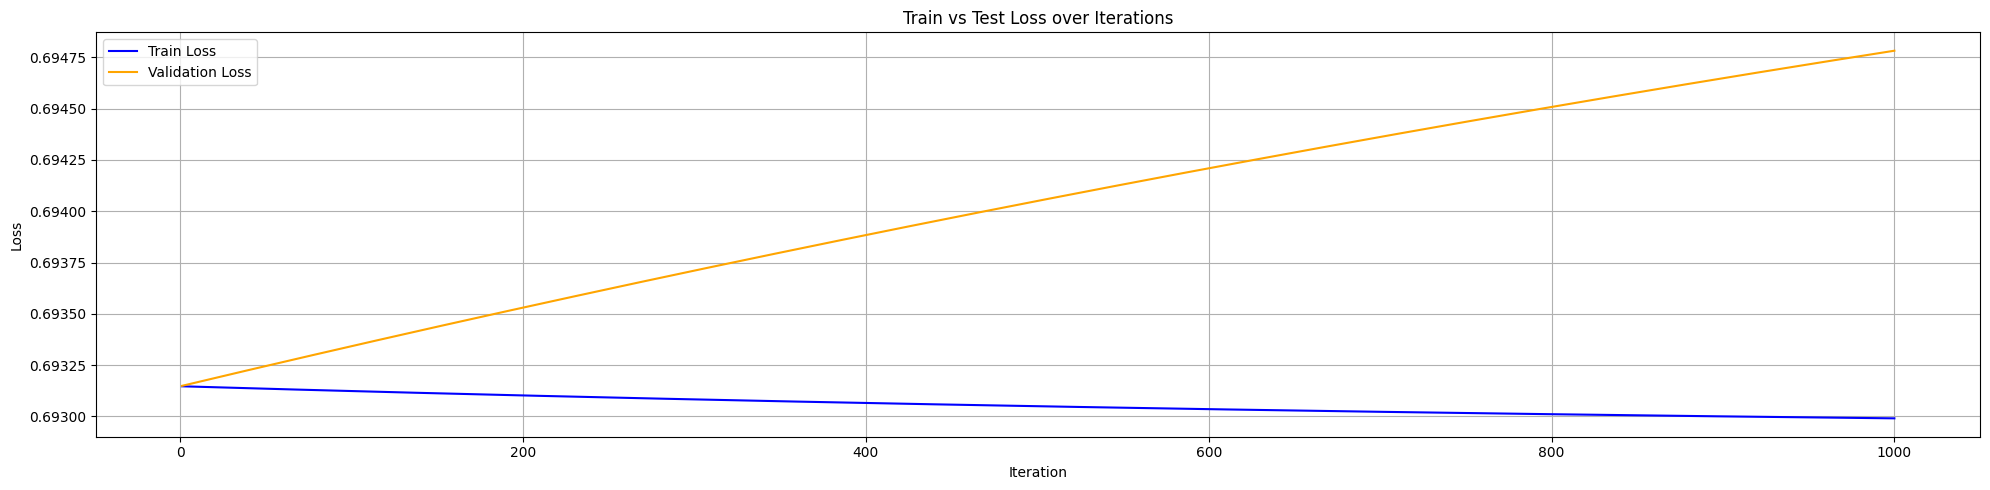

In [20]:
import matplotlib.pyplot as plt
iterations = range(1, iteration + 1)
plt.figure(figsize=(20, 5))
plt.plot(iterations, train_loss, label='Train Loss', color='blue')
plt.plot(iterations, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train vs Test Loss over Iterations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Reference: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)